### Import Modules 

In [68]:
import nltk
import numpy as np
import pandas as pd
import string
import re
import matplotlib.pyplot as plt

import warnings
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

### Load Dataset 

    - 5000개로 Dataset을 줄였습니다.  (train : 3000 / test : 2000) 
    
        5000개의 작은 데이터만 사용했음에도 Random Forest, SVM, Gradient Boosting Classifier의 성능을 잘 비교할 수 있었습니다.
    

In [69]:
data = pd.read_csv('./data/movie_data.csv', sep = ',')

data = data.sample(frac = 1) # Data Shuffle 
data = data[:5000]

### Data Preprocessing

       1. Remove Stopwords
       2. Remove Punctuation
       3. Tokenize
       4. lmemmatization

In [70]:
#Processing
stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.WordNetLemmatizer()

def clean_text(text):
    # Remove Punctuation
    text = ''.join([word.lower() for word in text if word not in string.punctuation])
    # make Token
    tokens = re.split('\W+', text)
    # Remove StopWords and make Stem
    text = [ps.lemmatize(word) for word in tokens if word not in stopwords]
    return text

### Vetorization 

    - TFIDF 사용

In [71]:
# Vectorization -- TF-IDF 
TFIDF_Vect = TfidfVectorizer(analyzer = clean_text)
X_TFIDF = TFIDF_Vect.fit_transform(data['review'])
X_TFIDF_pd = pd.DataFrame(X_TFIDF.toarray(), columns = TFIDF_Vect.get_feature_names())

C:\Users\USER\anaconda3\envs\torch_env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Train / Test set Split 

In [116]:
X_TFIDF_pd.shape

(5000, 46468)

In [78]:
x_train , y_train = X_TFIDF_pd[:3000] , data['sentiment'][:3000]
x_test , y_test = X_TFIDF_pd[3000:], data['sentiment'][3000:]

## Train Models : RF / SVM / GBC

### Random Forest

In [79]:
warnings.filterwarnings('ignore', category = DeprecationWarning)

rf = RandomForestClassifier()
param = {'n_estimators' : [10, 150, 300],
         'max_depth' : [30, 60, 90, None]}

gs = GridSearchCV(rf, param, cv = 3, n_jobs =4)
gs_fit = gs.fit(x_train, y_train)
result1 = pd.DataFrame(gs_fit.cv_results_).sort_values('mean_test_score', ascending = False)

In [80]:
rf_scores = result1['mean_test_score']
print("Mean Test Scores  : Random Forest ...  -----  " , list(rf_scores)[:5])

Mean Test Scores  : Random Forest ...  -----   [0.824, 0.8196666666666667, 0.816, 0.816, 0.8143333333333334]


### SVM 

In [81]:
svc = SVC(kernel = 'rbf' , probability=True)
param = {'gamma' : [0.1, 0.5, 1],
         'C' : [1, 5, 10]}

gs2 = GridSearchCV(svc, param, cv = 3, n_jobs = 4)
gs_fit2 = gs2.fit(x_train, y_train)
result2 = pd.DataFrame(gs_fit2.cv_results_).sort_values('mean_test_score', ascending = False)

In [82]:
svm_scores = result2['mean_test_score']
print("Mean Test Scores ...  : " , list(svm_scores)[:5])

Mean Test Scores ...  :  [0.844, 0.844, 0.8433333333333334, 0.8426666666666667, 0.8426666666666667]


### Gradient Boosting Classifier

In [83]:
gbc = GradientBoostingClassifier()
param = {'n_estimators' : [10, 50, 100, 200, 400]}

gs3 = GridSearchCV(gbc, param, cv = 3, n_jobs = 4)
gs_fit3 = gs3.fit(x_train, y_train)
result3 = pd.DataFrame(gs_fit3.cv_results_).sort_values('mean_test_score', ascending = False)

In [84]:
gb_scores = result3['mean_test_score']
print("Mean Test Scores ...  : " , list(gb_scores)[:5])

Mean Test Scores ...  :  [0.8016666666666667, 0.7923333333333334, 0.7763333333333334, 0.7623333333333333, 0.6863333333333334]


## Compare Result 

In [101]:
rf_scores = result1['mean_test_score']
svm_scores = result2['mean_test_score']
gb_scores = result3['mean_test_score']

### Best Parameters 

In [105]:
rf_scores = np.array(rf_scores)
svm_scores = np.array(svm_scores)
gb_scores = np.array(gb_scores)

print("RF  Best Parameters : ",result1.params[0])
print("SVM Best Parameters : ",result2.params[0])
print("GBC Best Parameters : ",result3.params[0])

RF  Best Parameters :  {'max_depth': 30, 'n_estimators': 10}
SVM Best Parameters :  {'C': 1, 'gamma': 0.1}
GBC Best Parameters :  {'n_estimators': 10}


### Best Train Result

In [113]:
print("RF  : ", rf_scores[0])
print("SVM : ", svm_scores[0])
print("GBC : ", gb_scores[0])

RF  :  0.824
SVM :  0.844
GBC :  0.8016666666666667


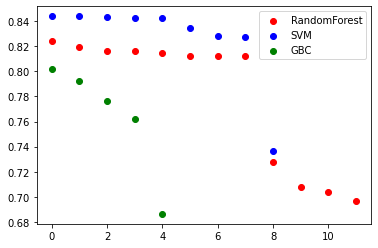

In [114]:
%matplotlib inline

plt.figure()
plt.scatter(np.arange(len(rf_scores)), rf_scores, c = 'r')
plt.scatter(np.arange(len(svm_scores)), svm_scores, c = 'b')
plt.scatter(np.arange(len(gb_scores)), gb_scores, c = 'g')
plt.legend(["RandomForest", "SVM", "GBC"])

plt.show()

왼쪽 순으로 높은 Score ... 

### Test Models 

In [91]:
rf_test_score = gs_fit.score(x_test, y_test)
svm_test_score = gs_fit2.score(x_test, y_test)
gb_test_score = gs_fit3.score(x_test, y_test)

### Test Score

In [111]:
print("# ---Test Score--- #")
print("RF  : ", rf_test_score)
print("SVM : ", svm_test_score)
print("GBC : ", gb_test_score)

# ---Test Score--- #
RF  :  0.8385
SVM :  0.86
GBC :  0.808


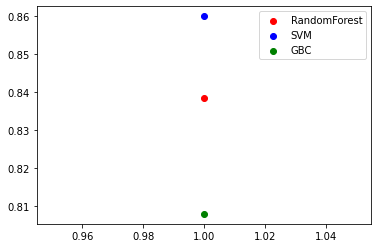

In [112]:
%matplotlib inline
plt.figure()
plt.scatter(1, rf_test_score, c = 'r')
plt.scatter(1, svm_test_score, c = 'b')
plt.scatter(1, gb_test_score, c = 'g')
plt.legend(["RandomForest", "SVM", "GBC"])
plt.show()

### Result and Discussion

3000개의 데이터를 이용하여 학습한 결과를 Visualize해보았다.  

Test 성능 : `SVM > Random Forest > Gradient Boosting Classifier`  
연산 속도 : `Random Forest > SVM >> Gradient Boosting Classifier`

해당 결과에 대한 개인적인 생각은 다음과 같다. 

우선 TF IDF 처리에 의해 feature의 개수가 매우 많아졌다.  
50000개의 데이터 중 5000개의 데이터만 이용하였음에도 feature 개수가 46468개로 임을 알 수 있고, 50000개 데이터를 모두 사용하였을 경우 16만개 이상의 feature가 생성된다.

따라서 차원의 저주를 일으키고, 충분한 양의 데이터 Sample을 가지고 훈련시키지 않는다면 제대로 훈련되지 않을 것을 유추할 수 있다.

---

`SVM`

매우 많은 feature를 학습해야 하므로, Non-Linear SVM으로 rbf Kernel을 사용하였다. 
rbf Kernel의 특성상 매우 많은 차원의 feature를 충분히 근사시켜 좋은 결과를 낼 수 있을 것이라 생각했고, 실제 출력 결과 또한 매우 준수했다.

`Random Forest and Gradient Boosting Classifier`

Nonlinear한 데이터를 학습하는데 좋은 모델들이지만, SVM 보다는 그 성능이 낮았다. 

GBC와 Random Forest는 동일하게 앙상블 기법을 이용한 모델이지만 서로 성능 차이가 두드러지게 나타났다. GBC와 RF의 차이점이라고 한다면 GBC는 이전에 학습한 모델이 다음 학습되는 모델에 영향을 주는 Boosting 기법을 , RF는 Bagging 기법을 사용한다는 것이다.

해당 데이터 셋에 대해서는 bagging 기법을 사용한 Random forest가 더 좋은 성능을 보인다는 뜻 인데, 이에 대한 이유를 생각해보았다.

우선 Bagging 기법을 사용한 모델은 안정성과 정확성을 향상시키는 데에 초점을 맞춘다.
즉, 높은 bias로 인한 Underfitting과 높은 Variance로 인한 Overfitting에 대한 문제를 해결하기 위한 방법인데, 각 훈련 모델에서 나타난 결과를 일종의 중간 값으로 맞추어 주기 때문에 위 두 가지 문제들에 대한 해답으로 선택됬다.

다음으로 Boosting 기법은 풀기 어려운 문제에 초점이 맞추어진 알고리즘이다.
해당 알고리즘은 이전에 틀렸던 문제에 대해 가중치를 부여하게 되는데, 동시에 정답에 대해서는 낮은 가중치를 부여한다. 따라서 오답에 더욱 집중할 수 있게 된다.

따라서 정확도가 높게 나타난다. 하지만 그와 동시에 Outliar에 취약하게 된다.


---


위 두 가지 기법의 특징으로 미루어보아, 우리가 다루는 dataset의 feature의 수가 많은 만큼 Underfitting의 위험도가 높다. 즉, Bagging 기법이 bias와 variance를 보정하는데 
큰 역할을 할 수 있는 환경이다. 

반대로 Boosting 기법의 측면에서 우리가 다루는 dataset의 feature들은 각각 매우 높은 차원의 데이터이기에 하나하나가 outliar처럼 보일 가능성이 매우 높다.
따라서 해당 모델의 취약점인 Ouliar를 다루는 부분 때문에 성능이 그다지 높지 않게 나온 것으로 추측되는 바이다.

### 고찰

이번 과제를 진행하며 매우 많은 Feature를 가진 dataset을 다룰 때 어떤 모델을 선택하는 것이 좋은 지에 대한 Insight를 얻게 되었다.

또한 하나의 모델이라 하여도, 내부 Parameter를 어떻게 선정하느냐가 매우 중요한 Issue가 될 수 있기에, 모델 검증 부분에서 Grid Search와 같은 방법이 꼭 필요하다고 느꼈다.

마찬가지로 같은 조건에 대해서 보다 일반적인 성능을 확인하기 위해 Cross validation 또한 중요하다고 생각한다.


